# Tensorboard

Based on **Patric Loeber** video: https://www.youtube.com/watch?v=c36lUUr864M&t=13890s

### Code from 13_feed_forward_net

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
############## TENSORBOARD ########################
import sys
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
# default 'log_dir' is "runs" - we'll be more specific here
writer = SummaryWriter("runs/mnist2")
###################################################

In [3]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [4]:
# hyper parameters
input_size = 784 # iumages size 28x28 -> 1d tensor
hidden_size = 500
num_classes = 10
num_epochs = 1
batch_size = 64
learning_rate = 0.001

In [5]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
    transform=transforms.ToTensor(), download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
    transform=transforms.ToTensor())

In [6]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,
    shuffle=False)

Size of the samples: torch.Size([64, 1, 28, 28]), size of the labels: torch.Size([64])


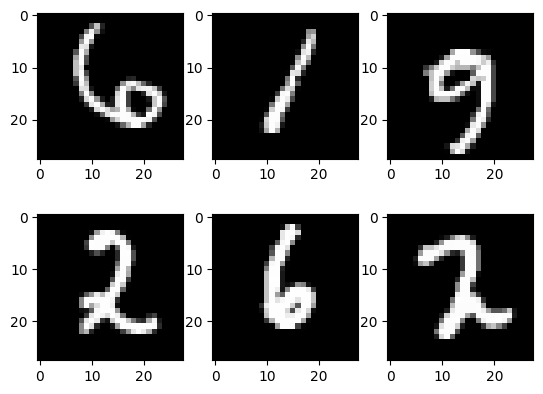

In [7]:
# on batch of data
examples = iter(train_loader)
example_data, example_targets = next(examples)
print(f"Size of the samples: {example_data.shape}, size of the labels: {example_targets.shape}")

for i in range(6):
    plt.subplot(2, 3, i+1) # 2 rows, 3 columns and index i+1
    plt.imshow(example_data[i][0], cmap='gray')
#plt.show()

In [8]:
############## TENSORBOARD ########################
img_grid = torchvision.utils.make_grid(example_data)
writer.add_image('mnist_images', img_grid)
#writer.close()
###################################################

In [9]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        # first layer
        self.l1 = nn.Linear(input_size, hidden_size)
        # activation function
        self.relu = nn.ReLU()
        # another linear layer
        self.l2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # here at the end we don't want an activation function
        # we don't apply softmax here like usuall in multi-class clasification problem
        # because we will see that we will use the cros entropy loss and this will apply softmax for us
        return out

In [10]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss() # cross entropy loss will apply softmax for use
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
############## TENSORBOARD ########################
# model graph
writer.add_graph(model, example_data.reshape(-1, 28*28).to(device))
#writer.close()
###################################################

In [12]:
# training loop
n_total_steps = len(train_loader)

running_loss = 0.0
running_correct = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # we will reshape our images first
        # because if we have a look at the shape we will see that it is 100, 1, 28, 28
        # and our input size is 100, 784
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # move the model to the same device as the data
        model = model.to(device)
        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        # updating parameters for us
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        # every 100 steps print 
        if (i+1) % 100 == 0:
            print(f"epoch {epoch+1} / {num_epochs}, step {i+1} / {n_total_steps}, loss = {loss.item():.4f}")
            ############## TENSORBOARD ######################## idk why it is not adding scalar
            writer.add_scalar('training loss', running_loss / 100, epoch * n_total_steps + i)
            running_accuracy = running_correct / 100 / predicted.size(0)
            writer.add_scalar('accuracy', running_accuracy, epoch * n_total_steps + i)
            running_loss = 0.0
            running_correct = 0
            writer.close()
            ###################################################

epoch 1 / 1, step 100 / 938, loss = 0.3999
epoch 1 / 1, step 200 / 938, loss = 0.3685
epoch 1 / 1, step 300 / 938, loss = 0.2509
epoch 1 / 1, step 400 / 938, loss = 0.1159
epoch 1 / 1, step 500 / 938, loss = 0.1916
epoch 1 / 1, step 600 / 938, loss = 0.1840
epoch 1 / 1, step 700 / 938, loss = 0.0921
epoch 1 / 1, step 800 / 938, loss = 0.1546
epoch 1 / 1, step 900 / 938, loss = 0.2682


In [13]:
# test the model
# in test phase, w don't need to compute gradients (for memory efficiency)
class_labels = []
class_preds = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        # value, !index!
        values, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        # for each correct prediction we add 1
        n_correct += (predicted == labels).sum().item()
        
        class_probs_batch = [F.softmax(output, dim=0) for output in outputs]
        
        class_preds.append(class_probs_batch)
        class_labels.append(labels)
        
    # 10000, 10, and 10000, 1
    # stack concatenates tensors along a new dimension
    # cat concatenates tensors in the given dimension
    class_preds = torch.cat([torch.stack(batch) for batch in class_preds])
    class_labels = torch.cat(class_labels)
    
    
    acc = 100.0 * n_correct / n_samples
    print(f"Accuracy of the network on the 10000 test images: {acc} %")
    
    ############## TENSORBOARD ########################
    classes = range(10)
    for i in classes:
        labels_i = class_labels == i
        preds_i = class_preds[:, i]
        writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
        writer.close()
    ###################################################

Accuracy of the network on the 10000 test images: 96.51 %
